In [1056]:
# Lets try simple logistic regression with no super sampling shit to see how it goes first
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, precision_recall_fscore_support
from sklearn.model_selection import train_test_split, cross_val_score
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import cross_validate
from sklearn.metrics import accuracy_score, SCORERS
import matplotlib as plt
%matplotlib inline
from matplotlib import rcParams
import pandas as pd
import numpy as np
import pprint as pp



stats = pd.read_csv('stats_1.5.csv')
stats.drop(labels='Unnamed: 0', axis=1, inplace=True)
stats['MVP'] = stats['MVP'].apply(lambda x : int(x))
stats['Impact_1'] = (stats['TmWin'] * stats['G']) / 82 
stats['Impact'] = stats['Impact_1'] * ((stats['MP'] / 48) * (stats['USG%']/100))
stats.drop(labels='Impact_1', axis=1, inplace=True)

In [1060]:
# Scoring metrics
SCORERS.keys()

# Or can use make_score to make own scoring metric see how

dict_keys(['explained_variance', 'r2', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'accuracy', 'roc_auc', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'brier_score_loss', 'adjusted_rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted'])

In [964]:
stats.head()

,Player,MVP,Year,Age,TmWin,G,GS,MP,PER,TS%,...,ORB/G,DRB/G,TRB/G,AST/G,STL/G,BLK/G,TOV/G,PF/G,PPG,Impact
0,A.C. Green,0,1986,22.0,62.0,82.0,1.0,1542.0,11.8,0.564,...,1.95,2.70,4.65,0.66,0.60,0.60,1.21,2.79,6.35,292.787250
1,A.C. Green,0,1987,23.0,65.0,79.0,72.0,2240.0,15.7,0.599,...,2.66,5.13,7.78,1.06,0.89,1.01,1.29,2.16,10.78,429.586585
2,A.C. Green,0,1988,24.0,62.0,82.0,64.0,2636.0,14.5,0.581,...,2.99,5.67,8.66,1.13,1.06,0.55,1.46,2.49,11.43,500.510500
3,A.C. Green,0,1989,25.0,57.0,82.0,82.0,2510.0,17.8,0.594,...,3.15,5.87,9.01,1.26,1.15,0.67,1.45,2.10,13.27,506.706250
4,A.C. Green,0,1990,26.0,63.0,82.0,82.0,2709.0,14.7,0.548,...,3.20,5.49,8.68,1.10,0.80,0.61,1.41,2.52,12.94,608.001188


In [965]:
X = stats[['WS', 'TOV/G', 'PF/G', 'TS%', 'AST/G', 'VORP', 'BLK/G', 'PPG', 'TRB/G', 'Impact', 'PER']]
y = stats['MVP']

In [966]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [967]:
sum = 0
for y in y_test:
    if y == 1 or y ==0:
        sum = sum + 1

sum
# Total of 106 MVPs candidates in the test set
# Total 3430 players in test set
print('Baseline Accuracy', (3430 - 106) / 3430)

Baseline Accuracy 0.9690962099125364


Accuracy : 0.9755
AUC Score : 0.970160
[[3299   25]
 [  59   47]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3324
           1       0.65      0.44      0.53       106

   micro avg       0.98      0.98      0.98      3430
   macro avg       0.82      0.72      0.76      3430
weighted avg       0.97      0.98      0.97      3430

AUC Score 0.9701598437890243
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9755102040816327


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0             0.5            0.0            0.5           0.0


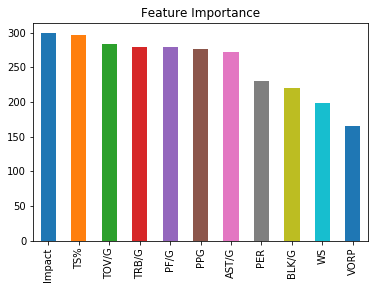

In [976]:
# Test run 1
xgb_class = XGBClassifier(learning_rate=0.5, scale_post_weight=1, min_child_weight=1, gamma=0, subsample=0.8,
                    nthread=4, objective='binary:logistic', n_estimators=500, seed=27)

xgb_class.fit(X_train, y_train)

predictions = xgb_class.predict(X_test)
predict_proba = xgb_class.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictions))
print("AUC Score : %f" % roc_auc_score(y_test, predict_proba[:,1]))


print(confusion_matrix(y_test, predictions))
print(classification_report(y_test, predictions))
print('AUC Score', roc_auc_score(y_test, predict_proba[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3299 + 47) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':1, 'gamma':0, 'subsample':0, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':500, 'seed':27}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_class.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [995]:
# Trying to tune the shit, test_run 1
param_t1 = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}

gsearch1 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265,
                                                gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27),
                        param_grid = param_t1, scoring='roc_auc', n_jobs=4, iid=False, cv=5)

gsearch1.fit(X_train, y_train)


print(gsearch1.best_params_)
print(gsearch1.best_score_)
pp.pprint(gsearch1.cv_results_)

{'max_depth': 9, 'min_child_weight': 1}
0.9669177350575712
{'mean_fit_time': array([2.04353037, 2.16919694, 2.48694692, 3.31632729, 3.10808473,
       3.02231436, 3.58421135, 3.2455173 , 3.27862883, 4.00807643,
       3.44558172, 3.26626196]),
 'mean_score_time': array([0.01376357, 0.01396289, 0.02014656, 0.01894937, 0.01855063,
       0.01914868, 0.01855021, 0.01755309, 0.01954765, 0.01835117,
       0.01815114, 0.01815114]),
 'mean_test_score': array([0.96614284, 0.96488194, 0.96482662, 0.96654008, 0.96591262,
       0.9612511 , 0.96645815, 0.96270233, 0.96277536, 0.96691774,
       0.96410311, 0.96321712]),
 'mean_train_score': array([1.        , 1.        , 0.99999984, 1.        , 1.        ,
       1.        , 1.        , 1.        , 1.        , 1.        ,
       1.        , 1.        ]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, Fal

Accuracy : 0.9723
AUC Score : 0.972164
[[3297   27]
 [  68   38]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3324
           1       0.58      0.36      0.44       106

   micro avg       0.97      0.97      0.97      3430
   macro avg       0.78      0.68      0.72      3430
weighted avg       0.97      0.97      0.97      3430

AUC Score 0.972163567422746
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9723032069970845


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.925136       0.010740       0.887036      0.019505
1         0.957986       0.005345       0.924659      0.022637
2         0.972698       0.007989       0.942086      0.022015
3         0.983039       0.004846       0.947612      0.018029
4         0.988511       0.002156       0.957994      0.011999
5         0.991901       0.001441       0.961822      0.007035
6         0.993906       0.001089       0.963282      0.007190
7         0.995141       0.000404       0.964932      0.004605
8         0.996081       0.000219       0.964462      0.003945
9         0.996556       0.000389       0.964474      0.004375
10        0.997008       0.000420       0.963880      0.004328
11        0.997578       0.000303       0.963541      0.004570
12        0.997968       0.000329       0.965213      0.004896
13        0.998334       0.000263       0.965011      0.005120
14        0.998600       0.000121       0.965822      0

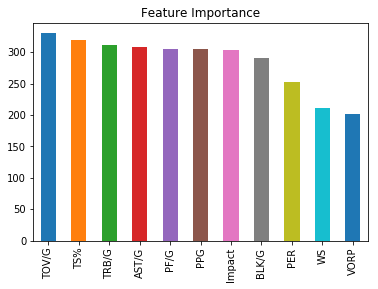

In [983]:
# Tune test 1
# Test run 1
xgb_classt1 = XGBClassifier(learning_rate=0.5, max_depth=9, scale_post_weight=1, min_child_weight=1, gamma=0, subsample=0.8,
                    nthread=4, objective='binary:logistic', n_estimators=265, seed=27, colsample_bytree=0.8)

xgb_classt1.fit(X_train, y_train)

predictionst1 = xgb_classt1.predict(X_test)
predict_probat1 = xgb_classt1.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst1))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat1[:,1]))


print(confusion_matrix(y_test, predictionst1))
print(classification_report(y_test, predictionst1))
print('AUC Score', roc_auc_score(y_test, predict_probat1[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 38) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':1, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.8}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt1.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [996]:
# Trying to tune the shit, test_run 2
param_t2 = {'max_depth':range(3,10,2), 'min_child_weight':range(1,6,2)}

gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265,
                                                gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27),
                        param_grid = param_t2, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch2.fit(X_train, y_train)


print(gsearch2.best_params_)
print(gsearch2.best_score_)
pp.pprint(gsearch2.cv_results_)

{'max_depth': 5, 'min_child_weight': 3}
0.39333333333333337
{'mean_fit_time': array([2.2890728 , 1.75271072, 1.84606123, 2.51766458, 2.32497959,
       2.22982945, 2.58468528, 2.43348932, 2.37803841, 2.75582738,
       3.04924245, 3.12025266]),
 'mean_score_time': array([0.01156917, 0.01017284, 0.01057186, 0.01256647, 0.01176858,
       0.01136985, 0.01276593, 0.01136961, 0.01136923, 0.01316495,
       0.01535859, 0.01495996]),
 'mean_test_score': array([0.39333333, 0.38333333, 0.38333333, 0.38666667, 0.39333333,
       0.36333333, 0.38666667, 0.38333333, 0.38333333, 0.35      ,
       0.39      , 0.39      ]),
 'mean_train_score': array([1.    , 1.    , 0.9925, 1.    , 1.    , 1.    , 1.    , 1.    ,
       1.    , 1.    , 1.    , 1.    ]),
 'param_max_depth': masked_array(data=[3, 3, 3, 5, 5, 5, 7, 7, 7, 9, 9, 9],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False, False],
       fill_value='?',
            dtype=object),

Accuracy : 0.9729
AUC Score : 0.968565
[[3297   27]
 [  66   40]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3324
           1       0.60      0.38      0.46       106

   micro avg       0.97      0.97      0.97      3430
   macro avg       0.79      0.68      0.72      3430
weighted avg       0.97      0.97      0.97      3430

AUC Score 0.968564811661331
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9728862973760933


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


   train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.921692       0.008507       0.889240      0.016444
1        0.955777       0.004893       0.918101      0.017553
2        0.964694       0.005755       0.938616      0.016364
3        0.974609       0.002823       0.951207      0.017232
4        0.981924       0.002396       0.959413      0.011902
5        0.985087       0.001522       0.963250      0.006819
6        0.988002       0.001056       0.967597      0.003619
7        0.989422       0.000729       0.969552      0.002673
8        0.990157       0.000422       0.969904      0.002546


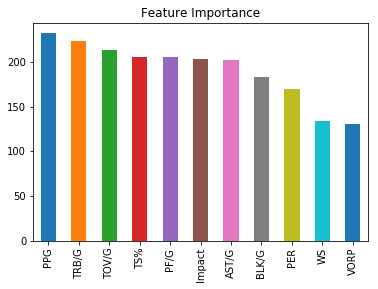

In [997]:
# Tune test 2
# Test run 2
xgb_classt2 = XGBClassifier(learning_rate=0.5, max_depth=5, scale_post_weight=1, min_child_weight=3, gamma=0, subsample=0.8,
                    nthread=4, objective='binary:logistic', n_estimators=265, seed=27, colsample_bytree=0.8)

xgb_classt2.fit(X_train, y_train)

predictionst2 = xgb_classt2.predict(X_test)
predict_probat2 = xgb_classt2.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst2))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat2[:,1]))


print(confusion_matrix(y_test, predictionst2))
print(classification_report(y_test, predictionst2))
print('AUC Score', roc_auc_score(y_test, predict_probat2[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 40) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':3, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.8,
          'max_depth':5}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt2.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [1001]:
# Trying to tune the shit, test_run 2
param_t2 = {'max_depth':range(0,11,1), 'min_child_weight':range(0,11,1)}

gsearch2 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265,
                                                gamma=0, subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27),
                        param_grid = param_t2, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch2.fit(X_train, y_train)


print(gsearch2.best_params_)
print(gsearch2.best_score_)
pp.pprint(gsearch2.cv_results_)

{'max_depth': 2, 'min_child_weight': 6}
0.40666666666666673
{'mean_fit_time': array([0.8207953 , 0.74420862, 0.7509901 , 0.74939504, 0.75557809,
       0.78470054, 0.84214654, 0.86109567, 0.85531154, 0.86089644,
       0.88104239, 1.28775482, 1.27698326, 1.30630517, 1.2921432 ,
       1.29194331, 1.29473577, 1.29214258, 1.27419076, 1.25424414,
       1.40304661, 1.71880159, 2.17218857, 2.09698949, 2.08881154,
       2.15224166, 2.10157747, 2.09200273, 2.07903795, 2.12970219,
       2.16002131, 2.20889034, 2.09758816, 2.95429583, 2.77677069,
       3.05203495, 2.96107759, 2.78135805, 2.78754296, 2.7576221 ,
       2.77058806, 2.82962971, 2.81207657, 2.78494945, 4.06951246,
       3.56166978, 3.53534255, 3.46672511, 3.52756257, 3.50482316,
       3.48866639, 3.54072728, 3.55708385, 3.83573842, 3.56147156,
       5.79828849, 4.86458564, 4.12755742, 4.02383509, 4.07988439,
       3.9627986 , 3.89857063, 3.86127005, 3.80262699, 4.07230625,
       4.49457626, 7.0449523 , 4.46046677, 4.234671

Accuracy : 0.9741
AUC Score : 0.970719
[[3300   24]
 [  65   41]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3324
           1       0.63      0.39      0.48       106

   micro avg       0.97      0.97      0.97      3430
   macro avg       0.81      0.69      0.73      3430
weighted avg       0.97      0.97      0.97      3430

AUC Score 0.9707189564743546
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9728862973760933


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.876922       0.033077       0.861648      0.037370
1         0.916519       0.014174       0.899056      0.015528
2         0.939076       0.004438       0.923620      0.007963
3         0.956173       0.004832       0.946382      0.011214
4         0.961853       0.005289       0.952300      0.010970
5         0.968366       0.004062       0.960885      0.009181
6         0.973036       0.001594       0.964545      0.005538
7         0.975396       0.001011       0.968303      0.002825
8         0.976246       0.000887       0.968786      0.002969
9         0.977222       0.000496       0.969492      0.003307
10        0.978143       0.000793       0.969828      0.003251
11        0.978737       0.000958       0.970039      0.003721
12        0.979239       0.000859       0.970199      0.004377
13        0.979631       0.000810       0.970164      0.004423
14        0.979922       0.000939       0.970199      0

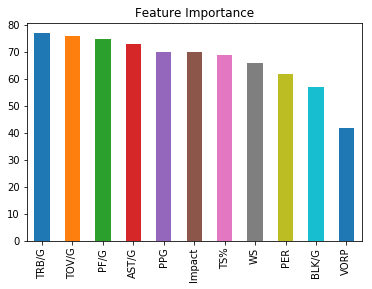

In [1002]:
# Tune test 3
# Test run 3
xgb_classt3 = XGBClassifier(learning_rate=0.5, max_depth=2, scale_post_weight=1, min_child_weight=6, gamma=0, subsample=0.8,
                    nthread=4, objective='binary:logistic', n_estimators=265, seed=27, colsample_bytree=0.8)

xgb_classt3.fit(X_train, y_train)

predictionst3 = xgb_classt3.predict(X_test)
predict_probat3 = xgb_classt3.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst3))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat3[:,1]))


print(confusion_matrix(y_test, predictionst3))
print(classification_report(y_test, predictionst3))
print('AUC Score', roc_auc_score(y_test, predict_probat3[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 40) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':6, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.8,
          'max_depth':2}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt3.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [1007]:
# Tune test 3 
paramt3 = {'gamma':[i/10.0 for i in range (0, 11)]}

gsearch3 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265, max_depth=2, min_child_weight=6,
                                                subsample=0.8, colsample_bytree=0.8, objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27),
                        param_grid = paramt3, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch3.fit(X_train, y_train)


print(gsearch3.best_params_)
print(gsearch3.best_score_)
pp.pprint(gsearch3.cv_results_)


{'gamma': 0.0}
0.40666666666666673
{'mean_fit_time': array([2.10935822, 1.73775034, 1.73017082, 1.63941336, 1.63741927,
       1.65098305, 1.64819007, 1.66953321, 1.75949259, 2.08462234,
       1.9605546 ]),
 'mean_score_time': array([0.0109694 , 0.0093751 , 0.0091753 , 0.00937505, 0.00977693,
       0.0095746 , 0.0095768 , 0.00957432, 0.01296558, 0.01236711,
       0.01176815]),
 'mean_test_score': array([0.40666667, 0.39      , 0.39      , 0.39      , 0.37666667,
       0.37666667, 0.37666667, 0.35333333, 0.35666667, 0.38666667,
       0.36666667]),
 'mean_train_score': array([0.86      , 0.86083333, 0.85833333, 0.85833333, 0.8625    ,
       0.86166667, 0.86583333, 0.8575    , 0.855     , 0.8525    ,
       0.84583333]),
 'param_gamma': masked_array(data=[0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0],
             mask=[False, False, False, False, False, False, False, False,
                   False, False, False],
       fill_value='?',
            dtype=object),
 'params'

In [1009]:
# Tune test 5 
paramt5 = {'subsample':[i/10.0 for i in range (0, 11)], 'colsample_bytree':[i/10.0 for i in range (0, 11)]}

gsearch5 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0),
                        param_grid = paramt5, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch5.fit(X_train, y_train)


print(gsearch5.best_params_)
print(gsearch5.best_score_)
pp.pprint(gsearch5.cv_results_)


{'colsample_bytree': 0.8, 'subsample': 0.8}
0.40666666666666673
{'mean_fit_time': array([0.91076236, 0.97399349, 1.05238409, 1.09048157, 1.10584087,
       1.18522873, 1.26401792, 1.25224943, 1.23090625, 1.22691703,
       1.07053537, 0.94726348, 1.08569484, 1.19121265, 1.22332654,
       1.25065355, 1.28815341, 1.27020106, 1.25923028, 1.24048085,
       1.50198154, 1.39825864, 1.24227614, 1.4367557 , 1.55783162,
       1.63223238, 1.68090281, 1.72378802, 1.85862641, 1.6934689 ,
       1.70982547, 1.70723228, 1.50417552, 1.2855598 , 1.67392144,
       1.84785647, 1.76447921, 1.85763021, 1.88016949, 1.94060783,
       1.92445149, 1.8400764 , 1.81873484, 1.65796423, 1.42738042,
       1.64499841, 1.81933222, 1.92405243, 2.04213614, 2.08562002,
       2.09758835, 2.07205572, 2.09300013, 2.11354499, 1.90550184,
       1.47625017, 1.80237813, 2.0431334 , 2.18036647, 2.23881054,
       2.38063116, 2.39858222, 2.37664165, 2.53561625, 2.42531114,
       2.2086906 , 1.67132859, 2.05131245, 2.30

In [1011]:
# Tune test 6
paramt6 = {'subsample':[i/100.0 for i in range (75,90,5)], 'colsample_bytree':[i/100.0 for i in range (75,90,5)]}

gsearch6 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic',
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0),
                        param_grid = paramt6, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch6.fit(X_train, y_train)


print(gsearch6.best_params_)
print(gsearch6.best_score_)
pp.pprint(gsearch6.cv_results_)

{'colsample_bytree': 0.75, 'subsample': 0.8}
0.40666666666666673
{'mean_fit_time': array([2.22830453, 1.557832  , 1.59393096, 1.59912105, 1.60370908,
       1.61388183, 1.6555707 , 1.68170066, 1.49340477]),
 'mean_score_time': array([0.00837789, 0.00917492, 0.00977335, 0.00857735, 0.00917592,
       0.00977378, 0.00917506, 0.0095737 , 0.00937486]),
 'mean_test_score': array([0.38666667, 0.40666667, 0.4       , 0.38666667, 0.40666667,
       0.4       , 0.39      , 0.37666667, 0.37333333]),
 'mean_train_score': array([0.855     , 0.86      , 0.86      , 0.855     , 0.86      ,
       0.86      , 0.855     , 0.86166667, 0.87583333]),
 'param_colsample_bytree': masked_array(data=[0.75, 0.75, 0.75, 0.8, 0.8, 0.8, 0.85, 0.85, 0.85],
             mask=[False, False, False, False, False, False, False, False,
                   False],
       fill_value='?',
            dtype=object),
 'param_subsample': masked_array(data=[0.75, 0.8, 0.85, 0.75, 0.8, 0.85, 0.75, 0.8, 0.85],
             mask=[

In [1012]:
# Tune test 7
paramt7 = {'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]}

gsearch7 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.8,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0),
                        param_grid = paramt7, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch7.fit(X_train, y_train)


print(gsearch7.best_params_)
print(gsearch7.best_score_)
pp.pprint(gsearch7.cv_results_)

{'reg_alpha': 0.01}
0.4133333333333333
{'mean_fit_time': array([2.14199753, 1.54347034, 1.55583744, 1.53828411, 1.07073469]),
 'mean_score_time': array([0.008178  , 0.00877662, 0.00857716, 0.00757995, 0.00578489]),
 'mean_test_score': array([0.39333333, 0.41333333, 0.38333333, 0.38333333, 0.        ]),
 'mean_train_score': array([0.87666667, 0.87833333, 0.8775    , 0.84      , 0.        ]),
 'param_reg_alpha': masked_array(data=[1e-05, 0.01, 0.1, 1, 100],
             mask=[False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'reg_alpha': 1e-05},
            {'reg_alpha': 0.01},
            {'reg_alpha': 0.1},
            {'reg_alpha': 1},
            {'reg_alpha': 100}],
 'rank_test_score': array([2, 1, 3, 4, 5]),
 'split0_test_score': array([0.41666667, 0.36666667, 0.43333333, 0.41666667, 0.        ]),
 'split0_train_score': array([0.86666667, 0.8625    , 0.86666667, 0.81666667, 0.        ]),
 'split1_test_score': array([0.36666667, 0.433

In [1047]:
# Tune test 8
paramt8 = {'reg_alpha':[0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05]}

gsearch8 = GridSearchCV(estimator=XGBClassifier(learning_rate=0.5, n_estimators=265, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0),
                        param_grid = paramt8, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch8.fit(X_train, y_train)


print(gsearch8.best_params_)
print(gsearch8.best_score_)
pp.pprint(gsearch8.cv_results_)

{'reg_alpha': 0.02}
0.43000000000000005
{'mean_fit_time': array([1.85423083, 1.69606233, 1.63861542, 1.54466691, 1.75450592,
       1.86002326, 2.13149748, 2.33475423]),
 'mean_score_time': array([0.00977459, 0.01037235, 0.01077213, 0.00897627, 0.00997357,
       0.00997396, 0.01037269, 0.01376281]),
 'mean_test_score': array([0.39333333, 0.38666667, 0.39      , 0.41333333, 0.43      ,
       0.37333333, 0.40666667, 0.39      ]),
 'mean_train_score': array([0.87666667, 0.87416667, 0.875     , 0.87833333, 0.875     ,
       0.8875    , 0.87583333, 0.88      ]),
 'param_reg_alpha': masked_array(data=[0, 0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05],
             mask=[False, False, False, False, False, False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'reg_alpha': 0},
            {'reg_alpha': 0.001},
            {'reg_alpha': 0.005},
            {'reg_alpha': 0.01},
            {'reg_alpha': 0.02},
            {'reg_alpha': 0.03},
            {'reg_alpha

Accuracy : 0.9711
AUC Score : 0.954025
[[3285   39]
 [  60   46]]
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      3324
           1       0.54      0.43      0.48       106

   micro avg       0.97      0.97      0.97      3430
   macro avg       0.76      0.71      0.73      3430
weighted avg       0.97      0.97      0.97      3430

AUC Score 0.9540250437072861
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9728862973760933


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.876922       0.033077       0.861648      0.037370
1         0.916519       0.014174       0.899056      0.015528
2         0.939077       0.004438       0.923607      0.007962
3         0.956174       0.004832       0.946381      0.011212
4         0.961855       0.005287       0.952300      0.010970
5         0.968370       0.004061       0.960895      0.009170
6         0.973040       0.001596       0.964539      0.005535
7         0.975424       0.001034       0.968315      0.002812
8         0.976255       0.000899       0.968791      0.002961
9         0.977245       0.000488       0.969502      0.003298
10        0.978151       0.000800       0.969839      0.003239
11        0.978739       0.000965       0.970038      0.003720
12        0.979237       0.000863       0.970202      0.004363
13        0.979626       0.000812       0.970183      0.004409
14        0.979919       0.000945       0.970225      0

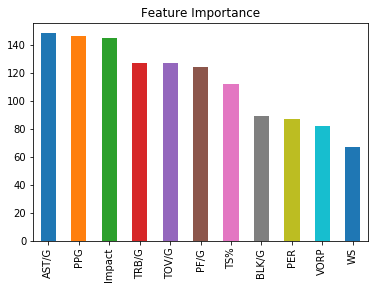

In [1045]:
# Test run 8
xgb_classt8 = XGBClassifier(learning_rate=1.3, n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.01)



xgb_classt8.fit(X_train, y_train)

predictionst8 = xgb_classt8.predict(X_test)
predict_probat8 = xgb_classt8.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst8))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat8[:,1]))


print(confusion_matrix(y_test, predictionst8))
print(classification_report(y_test, predictionst8))
print('AUC Score', roc_auc_score(y_test, predict_probat8[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 40) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':6, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.75,
          'max_depth':2, 'reg_alpha':0.02}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt8.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [1059]:
# Tune test 9
paramt9 = {'learning rate':[i/10.0 for i in range (0,25,1)]}

gsearch9 = GridSearchCV(estimator=XGBClassifier(n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.01),
                        param_grid = paramt9, scoring='recall', n_jobs=4, iid=False, cv=5)

gsearch9.fit(X_train, y_train)


print(gsearch9.best_params_)
print(gsearch9.best_score_)
pp.pprint(gsearch9.cv_results_)

{'learning rate': 0.0}
0.32333333333333336
{'mean_fit_time': array([4.68267131, 3.84591064, 3.55548787, 3.45954156, 3.51499658,
       3.46891942, 3.74717464, 4.22090764, 4.38247561, 4.45548024,
       4.39145098, 4.37848597, 4.48819232, 4.52090554, 5.2363914 ,
       5.27030039, 5.11730971, 4.80474567, 4.86079593, 4.97868099,
       5.12748256, 5.15361257, 5.26371808, 5.42348475, 5.19789443]),
 'mean_score_time': array([0.01535816, 0.01316504, 0.0133646 , 0.01376343, 0.01336441,
       0.01296563, 0.01516004, 0.01715436, 0.01675529, 0.01635594,
       0.01795249, 0.01795187, 0.01735396, 0.01795211, 0.02134414,
       0.01835093, 0.0199472 , 0.01974721, 0.02014666, 0.0195477 ,
       0.02094383, 0.02154312, 0.02114358, 0.02114353, 0.02094417]),
 'mean_test_score': array([0.32333333, 0.32333333, 0.32333333, 0.32333333, 0.32333333,
       0.32333333, 0.32333333, 0.32333333, 0.32333333, 0.32333333,
       0.32333333, 0.32333333, 0.32333333, 0.32333333, 0.32333333,
       0.32333333, 0.323

Accuracy : 0.8962
AUC Score : 0.802935
[[3004  320]
 [  36   70]]
              precision    recall  f1-score   support

           0       0.99      0.90      0.94      3324
           1       0.18      0.66      0.28       106

   micro avg       0.90      0.90      0.90      3430
   macro avg       0.58      0.78      0.61      3430
weighted avg       0.96      0.90      0.92      3430

AUC Score 0.8029354835047566
Accuracy (I.e. Total Correct Predictions / Total Predictions) 0.9728862973760933


C:\Users\kengw\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


    train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0         0.876922       0.033077       0.861648      0.037370
1         0.916519       0.014174       0.899056      0.015528
2         0.939076       0.004438       0.923620      0.007963
3         0.956173       0.004832       0.946382      0.011214
4         0.961855       0.005287       0.952301      0.010971
5         0.968369       0.004062       0.960887      0.009177
6         0.973040       0.001595       0.964539      0.005538
7         0.975423       0.001036       0.968312      0.002815
8         0.976256       0.000899       0.968788      0.002965
9         0.977246       0.000488       0.969507      0.003298
10        0.978152       0.000799       0.969842      0.003239
11        0.978743       0.000964       0.970043      0.003715
12        0.979241       0.000865       0.970206      0.004358
13        0.979632       0.000812       0.970185      0.004402
14        0.979924       0.000945       0.970226      0

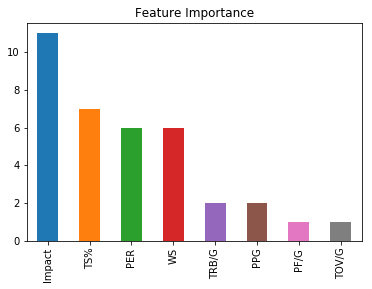

In [1117]:
# Test 9
# Test run 9
xgb_classt9 = XGBClassifier(learning_rate=2.5, n_estimators=500, max_depth=2, min_child_weight=6,
                                                objective='binary:logistic', subsample=0.8, colsample_by_tree = 0.75,
                                                nthread=4, scale_post_weight=1, seed=27, gamma=0, reg_alpha=0.01)



xgb_classt9.fit(X_train, y_train)

predictionst9 = xgb_classt9.predict(X_test)
predict_probat9 = xgb_classt9.predict_proba(X_test)

print("Accuracy : %.4g" % accuracy_score(y_test, predictionst9))
print("AUC Score : %f" % roc_auc_score(y_test, predict_probat9[:,1]))


print(confusion_matrix(y_test, predictionst9))
print(classification_report(y_test, predictionst9))
print('AUC Score', roc_auc_score(y_test, predict_probat9[:,1]))



print('Accuracy (I.e. Total Correct Predictions / Total Predictions)', (3297 + 40) / 3430)

params = {'learning_rate':0.5, 'scale_post_weight':1, 'min_child_weight':6, 'gamma':0, 'subsample':0.8, 
          'nthread':4, 'objective':'binary:logistic', 'n_estimators':265, 'seed':27, 'colsample_bytree':0.75,
          'max_depth':2, 'reg_alpha':0.01}

train = xgb.DMatrix(X_train, y_train)

cv_results = xgb.cv(dtrain=train, params=params, nfold=5, num_boost_round=50, early_stopping_rounds=10, metrics='auc',
                    as_pandas=True, seed=123)

print(cv_results)


feat_imp = pd.Series(xgb_classt9.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importance')

In [ ]:
predict